#Cahn-Hilliard with Legendre Basis

This example uses a Cahn-Hilliard model to compare two different bases representations to discretize the microstructure. One basis representaion uses the continuous indicator basis (also known as a primitive or binned basis) and the other uses Legendre polynomials. The example includes the background theory about using Legendre polynomials as a basis in MKS. The MKS with two different bases are compared with the standard spectral solution for the Cahn-Hilliard solution at both the calibration domain size and a scaled domain size. 

###Cahn-Hilliard Equation

The Cahn-Hilliard equation is used to simulate microstructure evolution during spinodial decomposition and has the following form,

$$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

where $\phi$ is a conserved ordered parameter and $\sqrt{\gamma}$ represents the width of the interface. In this example, the Cahn-Hilliard equation is solved using a semi-implicit spectral scheme with periodic boundary conditions, see  [Chang and Rutenberg](http://dx.doi.org/10.1103/PhysRevE.72.055701) for more details.

### Legendre Polynomial Basis for the Microstructure Function

#### Continuous Indicator Basis

Recall the previous
[Cahn-Hilliard example](http://pymks.org/rst/cahn_hilliard_Legendre.html),
the convolution at time $t$ is given by

$$ p\left[i, t \right] = \sum_{h=0}^{n-1} \alpha_h \left[j\right] m_h\left[i - j, t\right] $$

In this example the $p$ are an approximation of the updated $\phi$
such that,

$$ p \left[i, t\right] \approx \phi \left[i, t + \Delta t \right] $$

The `ContinuousIndicatorBasis` uses a simple primitive or binned basis
to discretize state space such that

$$ \phi\left[i\right] = \sum_{h=0}^{n-1} m_h\left[i\right] \chi_h $$

dropping the superscript. In this example, $-1 \le \phi \le 1$ so that
$\Delta h = 2 / (n - 1)$ where $n\ge2$ is the number of spatial bins.

The $\chi_h$ are given by $-1 + h \Delta h$. The $m_h$ can be represented by

$$ m_h \left[i\right] = R\left(1 - \frac{\left| \phi\left[i\right] - \chi_h \right|}{\Delta h}\right) $$

where $R$ is the
[ramp function](http://en.wikipedia.org/wiki/Ramp_function). There is
a mapping both ways between $\phi$ and $m_h$. See [Fast el al.](http://dx.doi.org/10.1016/j.actamat.2010.10.008) for further details on solving the Cahn-Hilliard equation with this basis.

#### Legendre Polynomial Basis

The microstructure function can also be represented using the
coefficients from a Legendre series, such that,

$$ m_h\left[i\right] = c_h \left[i\right] $$

where the $c_h$ are the coefficients in a Legendre series. As we shall
see, the coefficients turn out to be Legendre polynomials
themselves. The $m_h$ vector only needs to be a unique mapping from a
value $\phi$ so it is arbitrary in terms of how this is achieved. The
following steps show how to construct the $c_h$. Start with a Legendre
series,

$$ f \left( \eta, \phi \right) = \sum_{l = 0}^\infty c_{l} \left(\phi\right) P_l (\eta) $$

where $\eta$ is a continuous variable such $-1 \le \eta \le 1$ and
$\phi$ is a fixed value at a location in discretized space (the $[i]$
is dropped for convenience). Using

$$ \int_{-1}^{1} P_l \left( \eta \right)  P_h \left( \eta \right) d\xi = \delta_{lh}\frac{2}{2h + 1} $$

and the expression for $f$ above, we can write the $c_l$ as

$$ c_h \left(\phi\right) = \frac{2h +1}{2} \int_{-1}^1 P_h \left(\eta \right) f\left( \eta, \phi \right) d\eta $$

Now we choose $f$ such that

$$ f \left(\eta, \phi\right) = \delta\left(\phi - \eta \right) $$

where we are conveniently assuming that $\phi$ has the same range has
$\xi$ (a linear mapping would be needed if this wasn't the case). This
choice of a $\delta$ function is good in two ways, it allows the
integral to be easily evaluated and it also provides a unique mapping
between $\phi$ and $m_h$. Using this choice, the $m_h$ can be written
as

$$ m_h \left[i\right] = c_h \left[i\right] = \frac{2h +1}{2} P_h \left(\phi\left[i\right]\right) $$

For completeness, we can trivially construct a reverse mapping by
observing that $P_1 \left( x \right) = x$ so that $\phi = 2 m_1 / 3$.

Further description is required to show mathematically why the $P_n$
make such a good basis.

In this example, we will explore the differences when using the
Legendre polynomials as the basis function compared to the primitive
(binned) basis for the microstructure function.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

##Modeling with MKS

###Generating Calibration Datasets

Because the microstructure is a continuous field that can have a range of values and changes over time, the first order influence coefficients cannot be calibrated with delta microstructures. Instead a large number of simulations with random initial conditions will be used to calibrate the first order influence coefficients using linear regression. Let's show how this is done.

The function `make_cahnHilliard` from `pymks.datasets` provides a nice interface to generate calibration datasets for the influence coefficients. The funcion `make_cahnHilliard` requires the number of calibration samples given by `n_samples` and the size and shape of the domain given by `size`.

In [2]:
import pymks
from pymks.datasets import make_cahn_hilliard

L = 41
n_samples = 400
dt = 1e-2
np.random.seed(101)
size=(L, L)
X, y = make_cahn_hilliard(n_samples=n_samples, size=size, dt=dt)

The function `make_cahnHilliard` has generated `n_samples` number of random microstructures, `X`, and returned the same microstructures after they have evolved for one time step given by `y`. Let's take a look at one of them.

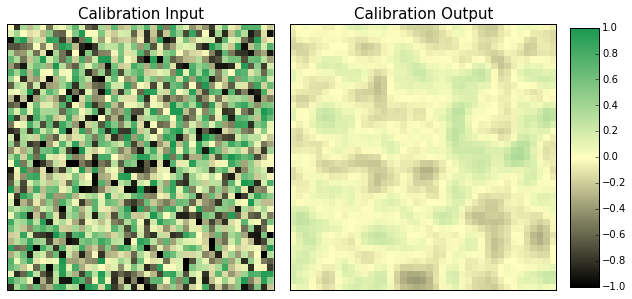

In [3]:
from pymks.tools import draw_concentrations

draw_concentrations((X[0], y[0]),('Calibration Input', 'Calibration Output'))

### Calibrate Influence Coefficients
 
In this example, we compare the difference between using the "primitive basis" and the Legendre polynomial basis to represent the microstructure function. As mentioned above, the microstructures (concentration fields) are not discrete phases. This leaves the number of local states in local state space `n_states` as a free hyper parameter. In the next section we look to see what a practical number of bins and Legendre polynomials would be. 
 
#### Optimizing the Number of Local States
 
Below, we compare the difference in performance as we vary the local state when we choose the binned basis and the Legendre polynomial basis.

The `(X, y)` sample data is split into training and test data. The code then optimizes `n_states` between `2` and `11` and the two `basis` with the `parameters_to_tune` variable. The `GridSearchCV` takes an `MKSLocalizationModel` instance, a `scoring` function (figure of merit) and the `parameters_to_tune` and then finds the optimal parameters with a grid search.

In [4]:
from pymks.bases import ContinuousIndicatorBasis
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
mse = metrics.mean_squared_error
from pymks.bases import LegendreBasis
from pymks import MKSLocalizationModel
from sklearn.cross_validation import train_test_split

train_split_shape = (X.shape[0],) + (np.prod(X.shape[1:]),)

X_train, X_test, y_train, y_test = train_test_split(X.reshape(train_split_shape),
                                                    y.reshape(train_split_shape),
                                                    test_size=0.5, random_state=3)

continuous_basis = ContinuousIndicatorBasis(2, [-1, 1])
legendre_basis = LegendreBasis(2, [-1, 1])

params_to_tune = {'n_states': np.arange(2, 11),
                 'basis': [continuous_basis, legendre_basis]}
model = MKSLocalizationModel(continuous_basis)
scoring = metrics.make_scorer(lambda a, b: -mse(a, b))
fit_params = {'size': size}
gs = GridSearchCV(model, params_to_tune, cv=5, fit_params=fit_params, n_jobs=6).fit(X_train, y_train)

The optimal parameters are a Legendre polynomial basis with only 4 terms. More terms don't improve the mean square error.

In [5]:
print(gs.best_estimator_)
print(gs.score(X_test, y_test))

MKSLocalizationModel(basis=<pymks.bases.legendre.LegendreBasis object at 0x7f5bd40a73d0>,
           n_states=4)
1.0


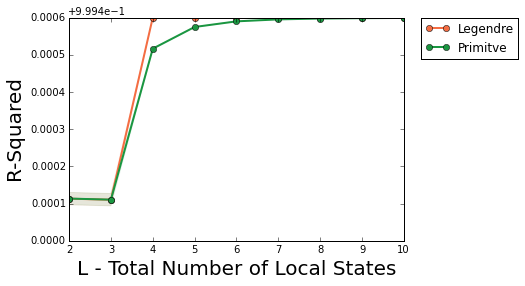

In [6]:
from pymks.tools import draw_gridscores

lgs = [x for x in gs.grid_scores_ \
       if type(x.parameters['basis']) is type(legendre_basis)]
cgs = [x for x in gs.grid_scores_ \
       if type(x.parameters['basis']) is type(continuous_basis)]

draw_gridscores([lgs, cgs], 'n_states', data_labels=['Legendre', 'Primitve'],
                colors=['#f46d43', '#1a9641'], score_label='R-Squared', 
                param_label = 'L - Total Number of Local States')

As you can see the `Legendre` basis converges faster than the binned basis. In order to further compare performance between the two models, lets select 4 local states for both bases.

### Comparing the Bases for `n_states=4`

In [7]:
PrimBasis = ContinuousIndicatorBasis(n_states=4, domain=[-1, 1])
PrimModel = MKSLocalizationModel(basis=PrimBasis)
PrimModel.fit(X, y)

LegendreBasis = LegendreBasis(4, [-1, 1])
LegendreModel = MKSLocalizationModel(basis=LegendreBasis)
LegendreModel.fit(X, y)

Now let's look at the influence coefficients for both bases.

First the binned basis influence coefficients

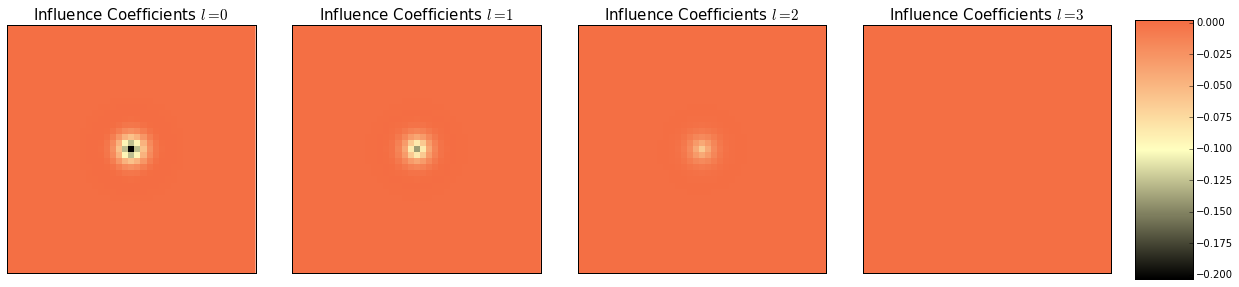

In [8]:
from pymks.tools import draw_coeff

draw_coeff(PrimModel.coeff)

Now for the Legendre polynomial basis influence coefficients.

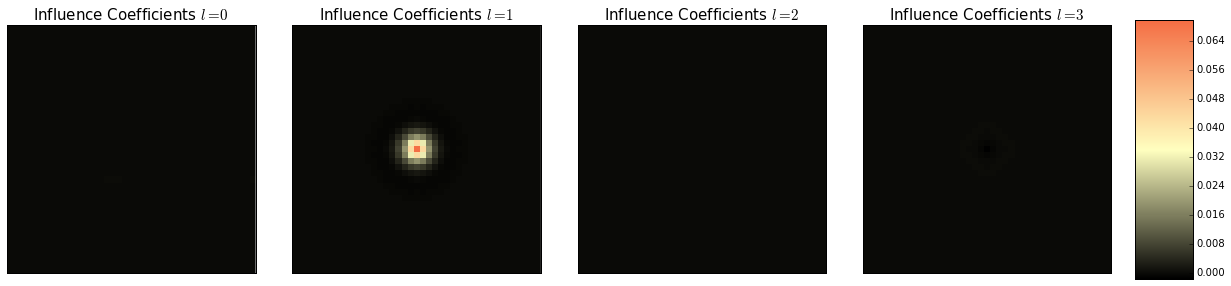

In [9]:
draw_coeff(LegendreModel.coeff)

Now let's do some simulations with both sets of coefficients and compare the results.

###Predict Microstructure Evolution

In order to compare the difference between the two bases, we need to have the Cahn-Hilliard simulation and the two MKS models start with the same initial concentration `phi0` and evolve in time. In order to do the Cahn-Hilliard simulation we need an instance of the class `CahnHilliardSimulation`.

In [10]:
from pymks.datasets.cahn_hilliard_simulation import CahnHilliardSimulation
np.random.seed(66)

phi0 = np.random.normal(0, 1e-9, ((n_samples,) + size))
CHSim = CahnHilliardSimulation(dt=dt)
phi_sim = phi0.copy()
phi_prim = phi0.copy()
phi_legendre = phi0.copy()



Let's look at the inital concentration field.

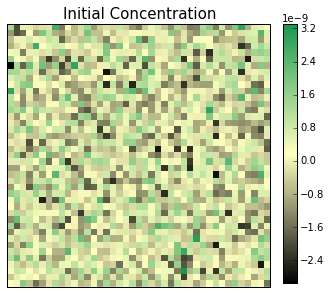

In [11]:
draw_concentrations([phi0[0]], ['Initial Concentration'])

In order to move forward in time, we need to feed the concentration back into the Cahn-Hilliard simulation and the MKS models.

In [12]:
time_steps = 55

for ii in range(time_steps):
    CHSim.run(phi_sim)
    phi_sim = CHSim.response
    phi_prim = PrimModel.predict(phi_prim)
    phi_legendre = LegendreModel.predict(phi_legendre)

Let's take a look at the concentration fields.

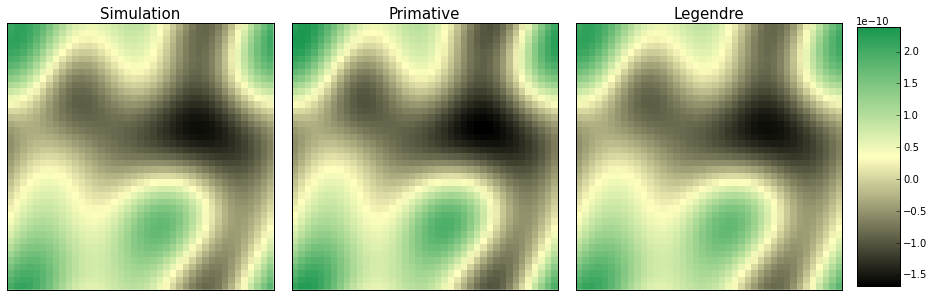

In [13]:
from pymks.tools import draw_concentrations

draw_concentrations((phi_sim[0], phi_prim[0], phi_legendre[0]),
                    ('Simulation', 'Primative', 'Legendre'))

By just looking at the three microstructures is it difficult to see any differences. Below, we plot the difference between the two MKS models and the simulation.

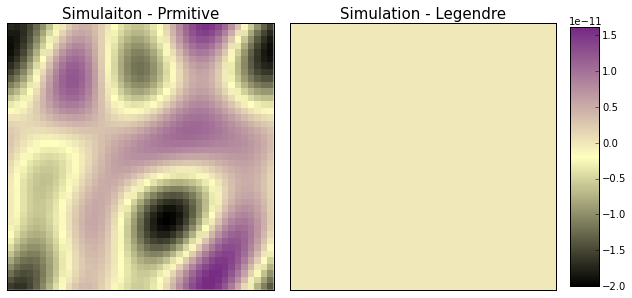

In [14]:
from sklearn import metrics
mse = metrics.mean_squared_error
from pymks.tools import draw_differences

draw_differences([(phi_sim[0] - phi_prim[0]), (phi_sim[0] - phi_legendre[0])],
                 ['Simulaiton - Prmitive', 'Simulation - Legendre'])

The Legendre polynomial basis clearly out performs the binned basis for the same value of `n_states`.

##Resizing the Coefficients to use on Larger Systems 

Below we compare the bases after the coefficients are resized.

In [15]:
N = 3 * L
PrimModel.resize_coeff((N, N))
LegendreModel.resize_coeff((N, N))

phi0 = np.random.normal(0, 1e-9, (1, N, N))
phi_sim = phi0.copy()
phi_prim = phi0.copy()
phi_legendre = phi0.copy()


Let's take a look at the initial large concentration field.

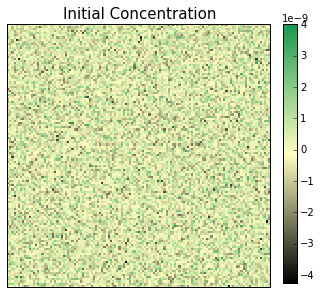

In [16]:
draw_concentrations([phi0[0]], ['Initial Concentration'])

Let's look at the resized coefficients.

First the influence coefficients from the binned bases.

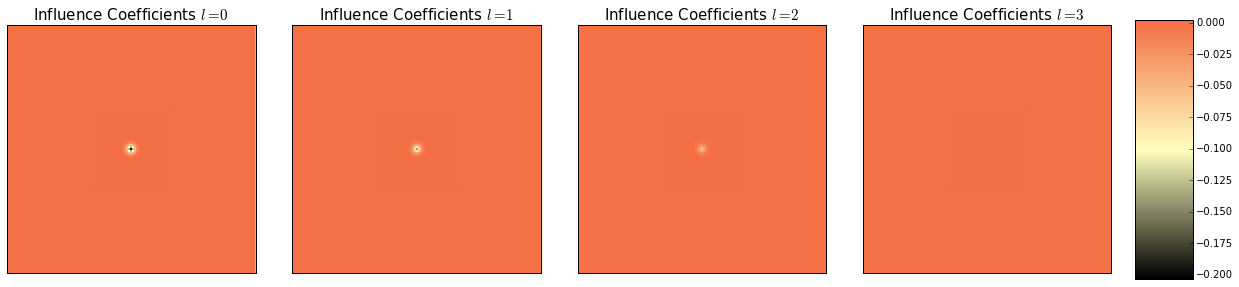

In [17]:
draw_coeff(PrimModel.coeff)

Now the influence coefficients from the Legendre polynomial bases.

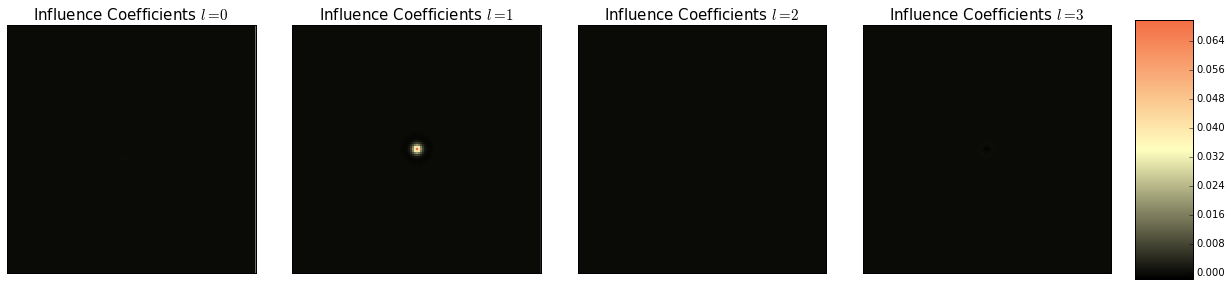

In [18]:
draw_coeff(LegendreModel.coeff)

Once again we are going to march forward in time by feeding the concentration fields back into the Cahn-Hilliard simulation and the MKS models. 

In [19]:
for ii in range(1000):
    CHSim.run(phi_sim)
    phi_sim = CHSim.response
    phi_prim = PrimModel.predict(phi_prim)
    phi_legendre = LegendreModel.predict(phi_legendre)

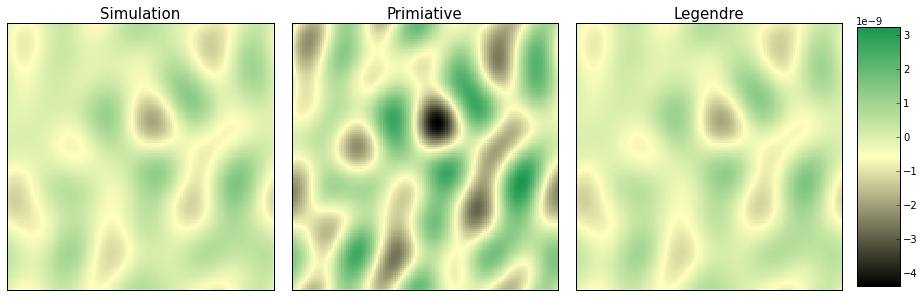

In [20]:
draw_concentrations((phi_sim[0], phi_prim[0], phi_legendre[0]), ('Simulation', 'Primiative', 'Legendre'))

Both the MKS models seem to predict the concentration faily well. However, the Legendre polynomial basis looks to be better. Again let's look at the difference between the simulation and the MKS models.

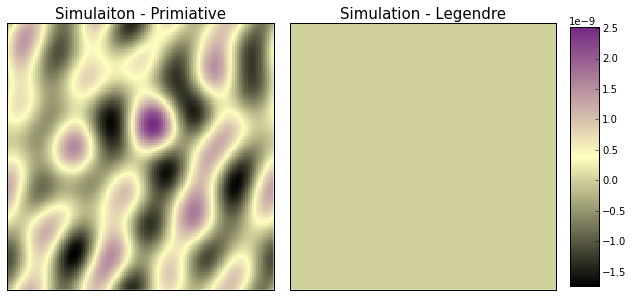

Primative mse = 5.40824187588e-19
Legendre mse = 5.11343260074e-25


In [21]:
draw_differences([(phi_sim[0] - phi_prim[0]), (phi_sim[0] - phi_legendre[0])], 
                 ['Simulaiton - Primiative','Simulation - Legendre'])
print 'Primative mse =', mse(phi_sim[0], phi_prim[0])
print 'Legendre mse =', mse(phi_sim[0], phi_legendre[0])

With the resized influence coefficients, the Legendre polynomial outperforms the binned basis for the same value of `n_states`. The value of `n_states` does not necessarily guarantee a fair comparison between the two basis in terms of floating point calculations and memory used.